# Error rates

If we have multiple outcome variables and want to perform statistical tests, then for each single test, the probability that we find a significant difference when there is no difference is $\alpha$, and the probability that we find a difference if there is a difference is the power $\beta$. The probability that we find significant results when we perform $k$ tests, given that there is no real difference then is $1-(1-\alpha)^k$. As $k$ gets very high, the chances are $\approx 1$. Therefore, we need to think about procedures to keep the _false discoveries_ low. A popular method is the *Bonferroni correction*, which is known to control these error rates well even if tests are not independent. However, it very much impairs power as *k* gets large. It will not be covered here. Before we talk about a procedure let us define some terms to evaluate it:  

$m$ = number of outcomes variables we want to perform a test on  
$R$ = number of positives (pvalue < $\alpha$)  
$V$ = number of false positives (type I error)  
$S$ = number of true positives   
$Q = \frac{V}{R} | R >0$ (Q is not the FDR, but its expectation is the FDR, see below)  
$m_0$ = number of outcomes where $H_0$ is true  
$m_1$ = number of outcomes where $H_1$ is true. 

Then, $m_0 - V$ is the number of true negatives and $m_1 - S$ is the number of false negatives (type II error). 


$P(V = 1 | m0 = 1) = \alpha$ ($\alpha$ **-level**)  
$P(S = 1 | m1 = 1) = \beta$ (**power**)   
$P(V \geq 1)$ is called **family wide error rate**


## False Discovery Rate

The procedure that I apply here is the **false discovery rate (FDR**), which is defined as:

$FDR = E\bigg(\frac{V}{R}|R>0\bigg)Pr(R>0)$

*The expected value of the proportion of type I errors is minimized. We can e.g. define the FDR to lead to an expected false discovery rate of 30%. This can be sensible if the goal is to explore data, where you then look more closely to the significant findings.*

The **Benjamini Hochberg procedure** allows us to keep the type I error below a predefined value. Given a list of pvalues, the function *p.adjust* returns a FDR for each pvalue. 

## Direct approach to FDR

This approach was described by [Storey](http://genomics.princeton.edu/storeylab/papers/directfdr.pdf). The procedure is:  
- pick a relatively large p-value cut-off, $\lambda$  
- assuming that tests obtaining p-values > $\lambda$ are mostly from cases in which the $H_0$ holds.
- then we estimate $\pi_0 = m_0/m$ as:  

$\hat{\pi_0} = \frac{n_{pi} >\lambda}{(1-\lambda)m}$

Once we have defined $\pi_0$, we can compute a q-value for each feature. This direct approach to FDR is implemented in the function *qvalue* of the package *qvalue*. 

In [261]:
library(tidyverse)

[1] 505

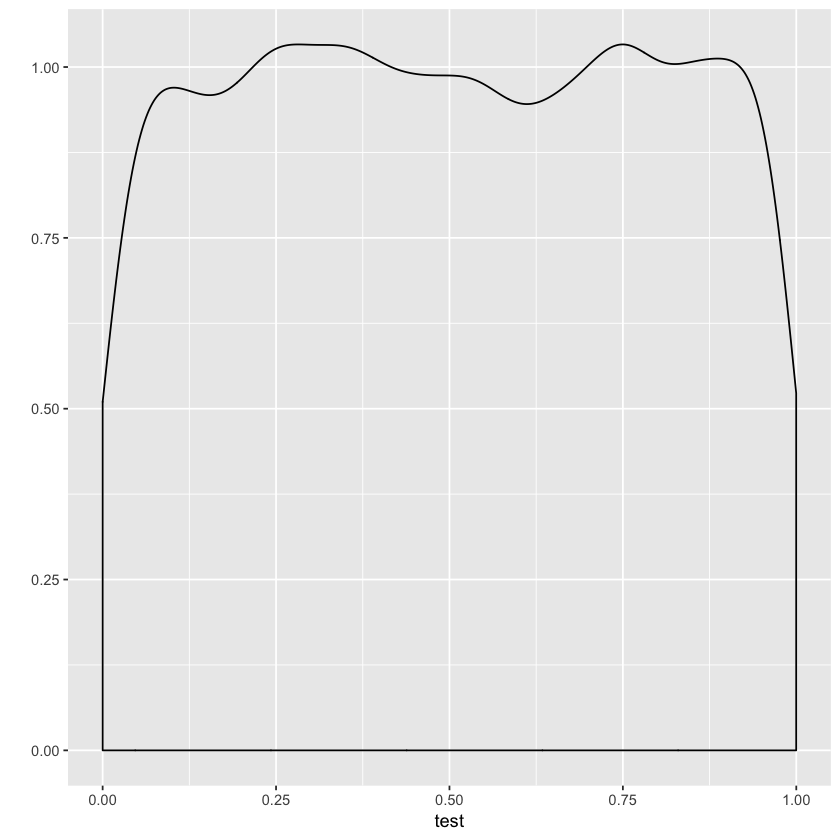

In [262]:
# simulate data, calculate p value (t-test), return p value
# a = mean group 1, b = difference to mean group 2
sim <- function(a, b, n, sd = 3) {
    # simulate y
    y1 <- rnorm(mean = a, sd = sd, n = n)
    y2 <- rnorm(mean = (a + b), sd = sd, n = n)
    test <- t.test(y1, y2)
    test$p.value 
}

# 1e5 t-tests if m1 = 0: how is the p value distributed?
test <- vapply(1:1e4, sim, 10, 0, 30)
qplot(test, geom = "density")
# what is R for alpha = 0.05? In this case R = V, since m1 = 0
sum(test < 0.05)

[1] 3379

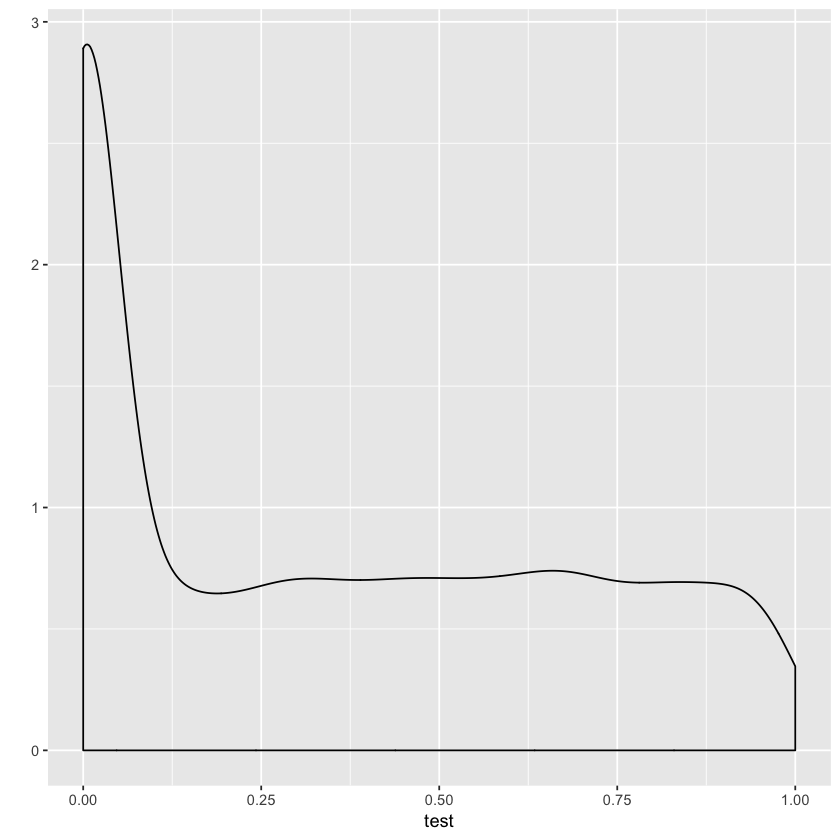

In [263]:
m0 <- 7000
m1 <- 3000
test <- c(vapply(1:m0, sim, 10, 0, 30), vapply(1:m1, sim, 10, 100, 30))
qplot(test, geom = "density")
# what is R for alpha = 0.05? 
sum(test < 0.05)

In the following, I perform 10000 t-tests and reject/accept the $H_0$ either based on pvalues (regular) or on FDR (fdr). Since we know the truth, we can evaluate FDR.

In [280]:
N <- 30
alpha <- 0.05
m <- 1e4
p0 <- 0.9 # rate H0 = true
m0 <- m * p0
m1 <- m - m0
h_null <- c(rep(TRUE, m0), rep(FALSE, m1))
# mean
a <- 24
# true effect if H1
delta <- 3
# sd for rnorm
sd <- 3.5
# rowtests requires a grouping factor variable
g <- factor(c(rep(0, N), rep(1, N)))
B <- 10 # number of simulations

set.seed(1)
# now calculate V and S
regular <- replicate(B, {
    # simulate samples for control group
    c_samples <- rnorm(mean = a, sd = sd, n = N*m)
    # rows are values, columns are subject
    control <- matrix(c_samples, nrow = m)
    # simulate samples treatment group
    t_samples <- rnorm(mean = a, sd = sd, n = N*m)
    treatment <- matrix(t_samples, nrow = m)
    treatment[which(!h_null), ] <- treatment[which(!h_null), ] + delta
    # combine to one matrix
    dat <- cbind(control, treatment)
    # pvalues 
    pvalues <- genefilter::rowttests(dat, g)$p.value
    rejected <- pvalues < alpha
    # V, S,
    R <- sum(rejected)
    V <- sum(rejected & h_null)
    S <- sum(rejected & !h_null)
    type_II <- sum(!h_null & !rejected)
    h0_true <- sum(h_null & !rejected)
    Q = ifelse(R>0, round(V/R, 3), 0 )
    c(R, V, S, type_II, h0_true, Q)
})

regular <- regular %>% t() %>% as.tibble()
colnames(regular) <- c("R", "V", "S", "type_II", "h0_true", "Q")
regular <- 
    regular %>%
        mutate(
            power = S/m1, 
            error_rate_I = round(V/m0, 3), 
            error_rate_II = round(type_II/m1, 3))


set.seed(1)
# now using FDR
# now calculate V and S
fdr <- replicate(B, {
    # simulate samples for control group
    c_samples <- rnorm(mean = a, sd = sd, n = N*m)
    # rows are values, columns are subject
    control <- matrix(c_samples, nrow = m)
    # simulate samples treatment group
    t_samples <- rnorm(mean = a, sd = sd, n = N*m)
    treatment <- matrix(t_samples, nrow = m)
    treatment[which(!h_null), ] <- treatment[which(!h_null), ] + delta
    # combine to one matrix
    dat <- cbind(control, treatment)
    # pvalues 
    pvalues <- genefilter::rowttests(dat, g)$p.value
    qvalues <- p.adjust(pvalues, method = "fdr")
    rejected <- qvalues < alpha
    # V, S,
    R <- sum(rejected)
    V <- sum(rejected & h_null)
    S <- sum(rejected & !h_null)
    type_II <- sum(!h_null & !rejected)
    h0_true <- sum(h_null & !rejected)
    Q = ifelse(R>0, round(V/R, 3), 0 )
    c(R, V, S, type_II, h0_true, Q)
})

fdr <- fdr %>% t() %>% as.tibble()
colnames(fdr) <- c("R", "V", "S", "type_II", "h0_true", "Q")
fdr <- 
    fdr %>%
        mutate(
            power = S/m1, 
            error_rate_I = round(V/m0, 3), 
            error_rate_II = round(type_II/m1, 3))


set.seed(1)
# finally the direct approach to FDR (Storey)
# now calculate V and S
storey <- replicate(B, {
    # simulate samples for control group
    c_samples <- rnorm(mean = a, sd = sd, n = N*m)
    # rows are values, columns are subject
    control <- matrix(c_samples, nrow = m)
    # simulate samples treatment group
    t_samples <- rnorm(mean = a, sd = sd, n = N*m)
    treatment <- matrix(t_samples, nrow = m)
    treatment[which(!h_null), ] <- treatment[which(!h_null), ] + delta
    # combine to one matrix
    dat <- cbind(control, treatment)
    # pvalues 
    pvalues <- genefilter::rowttests(dat, g)$p.value
    qvalues <- qvalue::qvalue(pvalues)$qvalues
    rejected <- qvalues < alpha
    # V, S,
    R <- sum(rejected)
    V <- sum(rejected & h_null)
    S <- sum(rejected & !h_null)
    type_II <- sum(!h_null & !rejected)
    h0_true <- sum(h_null & !rejected)
    Q = ifelse(R>0, round(V/R, 3), 0 )
    c(R, V, S, type_II, h0_true, Q)
})

storey <- storey %>% t() %>% as.tibble()
colnames(storey) <- c("R", "V", "S", "type_II", "h0_true", "Q")
storey <- 
    storey %>%
        mutate(
            power = S/m1, 
            error_rate_I = round(V/m0, 3), 
            error_rate_II = round(type_II/m1, 3))

regular
fdr
storey

R,V,S,type_II,h0_true,Q,power,error_rate_I,error_rate_II
1405,506,899,101,8494,0.360,0.899,0.056,0.101
1344,447,897,103,8553,0.333,0.897,0.050,0.103
1335,432,903,97,8568,0.324,0.903,0.048,0.097
1373,467,906,94,8533,0.340,0.906,0.052,0.094
1347,458,889,111,8542,0.340,0.889,0.051,0.111
1386,483,903,97,8517,0.348,0.903,0.054,0.097
1326,417,909,91,8583,0.314,0.909,0.046,0.091
1347,431,916,84,8569,0.320,0.916,0.048,0.084
1360,477,883,117,8523,0.351,0.883,0.053,0.117
1363,453,910,90,8547,0.332,0.910,0.050,0.090


R,V,S,type_II,h0_true,Q,power,error_rate_I,error_rate_II
606,26,580,420,8974,0.043,0.580,0.003,0.420
618,21,597,403,8979,0.034,0.597,0.002,0.403
596,20,576,424,8980,0.034,0.576,0.002,0.424
616,26,590,410,8974,0.042,0.590,0.003,0.410
567,21,546,454,8979,0.037,0.546,0.002,0.454
631,33,598,402,8967,0.052,0.598,0.004,0.402
670,31,639,361,8969,0.046,0.639,0.003,0.361
670,38,632,368,8962,0.057,0.632,0.004,0.368
623,39,584,416,8961,0.063,0.584,0.004,0.416
601,29,572,428,8971,0.048,0.572,0.003,0.428


R,V,S,type_II,h0_true,Q,power,error_rate_I,error_rate_II
644,37,607,393,8963,0.057,0.607,0.004,0.393
628,21,607,393,8979,0.033,0.607,0.002,0.393
620,22,598,402,8978,0.035,0.598,0.002,0.402
643,32,611,389,8968,0.050,0.611,0.004,0.389
579,23,556,444,8977,0.040,0.556,0.003,0.444
641,33,608,392,8967,0.051,0.608,0.004,0.392
684,33,651,349,8967,0.048,0.651,0.004,0.349
682,38,644,356,8962,0.056,0.644,0.004,0.356
641,41,600,400,8959,0.064,0.600,0.005,0.400
622,32,590,410,8968,0.051,0.590,0.004,0.410


As we can see in the dataframes, FDR succesfully limits type I errors. It impairs power at the same time but much less than e.g. Bonferroni correction. In the table we also see the value of *Q*, which is also a random variable and is the proportion of false discoveries out of all rejected $H_0$s. But it is not the FDR. The expectation of Q is the FDR

## FDR Exercises

In [288]:
library(devtools)
library(rafalib)
library(genefilter)
library(GSE5859Subset)
data(GSE5859Subset)

In [289]:
df <- geneExpression
head(df)
head(sampleInfo)

,GSM136508.CEL.gz,GSM136530.CEL.gz,GSM136517.CEL.gz,GSM136576.CEL.gz,GSM136566.CEL.gz,GSM136574.CEL.gz,GSM136575.CEL.gz,GSM136569.CEL.gz,GSM136568.CEL.gz,GSM136559.CEL.gz,⋯,GSM136727.CEL.gz,GSM136510.CEL.gz,GSM136515.CEL.gz,GSM136522.CEL.gz,GSM136507.CEL.gz,GSM136524.CEL.gz,GSM136514.CEL.gz,GSM136563.CEL.gz,GSM136564.CEL.gz,GSM136572.CEL.gz
1007_s_at,6.543954,6.401470,6.298943,6.837899,6.470689,6.450220,6.052854,6.387026,6.640583,6.948474,⋯,6.133068,6.502051,6.331567,6.354293,6.517539,6.156754,6.037871,6.639091,6.393338,6.469794
1053_at,7.546708,7.263547,7.201699,7.052761,6.980207,7.096195,6.983827,7.060558,7.010453,6.775048,⋯,7.280781,7.302209,7.456509,7.282859,7.689282,7.491967,7.413133,7.028731,6.697240,7.092346
117_at,5.402622,5.050546,5.024917,5.304313,5.214149,5.173731,5.022882,5.175134,5.281784,5.309194,⋯,5.401876,5.395087,5.280535,4.986950,5.562001,5.039387,5.054133,5.361298,5.218937,5.340272
121_at,7.892544,7.707754,7.461886,7.558130,7.819013,7.641136,7.729267,7.700608,7.615513,7.992304,⋯,7.607461,7.993732,7.632947,7.706585,7.612557,7.543667,7.507113,7.798197,7.976375,7.753480
1255_g_at,3.242779,3.222804,3.185605,3.195363,3.251915,3.324934,3.088541,3.184015,3.076940,3.167413,⋯,3.225123,3.440186,3.185090,3.192436,3.107306,3.128269,3.085953,3.174794,3.409032,3.274033
1294_at,7.531754,7.090270,7.466018,7.122145,7.058973,6.992396,7.112384,7.194791,6.884312,7.401553,⋯,7.018479,7.478820,7.577597,7.339535,7.398595,7.359040,7.377372,7.467240,7.355222,6.910401


,ethnicity,date,filename,group
107,ASN,2005-06-23,GSM136508.CEL.gz,1
122,ASN,2005-06-27,GSM136530.CEL.gz,1
113,ASN,2005-06-27,GSM136517.CEL.gz,1
163,ASN,2005-10-28,GSM136576.CEL.gz,1
153,ASN,2005-10-07,GSM136566.CEL.gz,1
161,ASN,2005-10-07,GSM136574.CEL.gz,1


In [297]:
ttests <- rowttests(df, as.factor(sampleInfo$group))
pvalues <- ttests$p.value
# how many  p values smaller than 0.05
sum(pvalues < 0.05)
# FWER < 0.05 (Bonferroni)
sum(pvalues < (0.05/dim(df)[1]))
# fdr < 0.05
qvalues_padjust <- p.adjust(pvalues, method = "fdr")
sum(qvalues_padjust < 0.05)
# qvalues (storey) < 0.05
qvalues_qvalue <- qvalue::qvalue(pvalues)$qvalues
sum(qvalues_qvalue < 0.05)
# estimates proportion of genes for which H0 is true
qvalue::qvalue(ttests$p.value)$pi0

[1] 1383

[1] 10

[1] 13

[1] 22

[1] 0.6695739

Create a Monte Carlo Simulation in which you simulate measurements from 8,793 genes for 24 samples: 12 cases and 12 controls. Now for 500 genes, there is a difference of 2 between cases and controls: So the null hypothesis is true for 8793-500 genes. Using the notation from the videos m=8793, m0=8293 and m1=500

Set the seed at 1, set.seed(1) and run this experiment 1,000 times with a Monte Carlo simulation. For each instance compute p-values using a t-test (using rowttests in the genefilter package) and create three lists of genes using:

Bonferroni correction to achieve an FWER of 0.05,
p-adjust estimates of FDR to achieve an FDR of 0.05, and
qvalue estimates of FDR to to achieve an FDR of 0.05.
For each of these three lists compute the number of false positives in the list and the number of false negatives: genes not in the list that should have been because the null hypothesis is not true (we added 2 to the controls to create the cases).

In [342]:
n <- 24
m <- 8793
m1 <- 500
m0 <- m - m1
g <- c(rep(0, n/2), rep(1, n/2)) %>% as.factor()
set.seed(1)
B <- 1000
alpha <- 0.05

fp_rate_bf <- list()
fn_rate_bf <- list()
fp_rate_fdr <- list()
fn_rate_fdr <- list()
fp_rate_storey <- list()
fn_rate_storey <- list()

mat_result <-
    replicate(B, {
        mat <- matrix(rnorm(n*m), m, n)
        delta <- 2
        positives <- 500
        mat[1:positives, 1:(n/2)] <- mat[1:positives, 1:(n/2)] + delta
        # perform ttest
        pvalues <- rowttests(mat, g)$p.value
        qvalue_fdr <- p.adjust(pvalues, method = "fdr")
        qvalue_storey <- qvalue::qvalue(pvalues)$qvalues
        result <- tibble(
            rn = 1:m, 
            pvalue = pvalues,
            bonferroni = pvalue < alpha/m,
            fdr = qvalue_fdr < alpha,
            storey = qvalue_storey < alpha
            )
        # fp = false positive, bf = bonferroni etc...
        fp_bf <- sum(result$bonferroni & result$rn > 500)/m0
        fn_bf <- sum(!result$bonferroni & result$rn <= 500)/m1
        # fdr
        fp_fdr <- sum(result$fdr & result$rn > 500)/m0
        fn_fdr <- sum(!result$fdr & result$rn <= 500)/m1
        # direct approach fdr
        fp_storey <- sum(result$storey & result$rn > 500)/m0
        fn_storey <- sum(!result$storey & result$rn <= 500)/m1
        c(fp_bf, fn_bf, fp_fdr, fn_fdr, fp_storey, fn_storey)
})



In [344]:
mat_result %>% t() %>% 
    as.tibble() %>%
    summarise_all(mean)

V1,V2,V3,V4,V5,V6
5.305679e-06,0.763252,0.002737851,0.081418,0.002933076,0.077302


It seems that the direct approach to FDR is an approach that has a bit more power but also is a bit less conservative. I think that is depends on the goal which method works best. The Bonferroni method also works fine for independent test. How about the FDR approaches? This is something I need to keep in mind.